In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random

In [2]:
def create_graph(edges):
    # Create an undirected graph
    graph = nx.Graph()

    # Add edges to the graph
    # You can customize this part based on your specific graph or load it from external data
    graph.add_edges_from(edges)

    return graph

def set_upper_bounds(graph):
    upper_bounds = {}

    # Get user input for upper degree constraints
    for node in graph.nodes():
        while True:
            try:
                upper_bound = int(input(f"Enter upper degree constraint for node {node}: "))
                if upper_bound >= 0:
                    upper_bounds[node] = upper_bound
                    break
                else:
                    print("Please enter a non-negative integer.")
            except ValueError:
                print("Invalid input. Please enter a valid integer.")

    return upper_bounds

def calculate_delta(graph, upper_bounds):
    delta_values = {}

    # Calculate delta for each vertex
    for node in graph.nodes():
        degree = graph.degree(node)
        upper_bound = upper_bounds[node]
        delta = degree - upper_bound
        delta_values[node] = delta

    return delta_values

def create_bipartite_graph(node, delta, degree):
    
    delta_value = node + delta
    
    bipartite_graph = nx.Graph()

    # Add nodes to the first class
    # range starts from node value to node+delta value
    bipartite_graph.add_nodes_from(range(node, delta_value), bipartite=0)

    # Add nodes to the second class
    bipartite_graph.add_nodes_from(range(delta_value,  delta_value + degree), bipartite=1)

    # Add edges between nodes of opposite classes
    bipartite_graph.add_edges_from([(i, j) for i in range(node, delta_value) for j in range(delta_value, delta_value + degree)])
    
    
    temp_primary_edge = 0
    rm_char = ''
    
    #getting edges from eact subgraphs
    for primary_edge, secondary_edge in bipartite_graph.edges():
        # checking subgraph edges is same as individual node value
        if primary_edge == node:
            # created edges for entire graph 
            edge = (node, str(node) + str(secondary_edge))
        else:
            #using random characters for sub graph edges
            if temp_primary_edge != primary_edge:
                rm_c = chr(random.randint(65, 90))
                rm_char = rm_c

            # created edges for entire graph 
            edge = (str(node)+rm_char, str(node) + str(secondary_edge))
            temp_primary_edge = primary_edge
            
        #appending edges
        grp.append(edge)
        
    return (bipartite_graph, node)


def display_all_bipartite_graphs(bipartite_graphs):
    
    plt.figure(figsize=(12, 8))
    
    for i, (bipartite_graph, node) in enumerate(bipartite_graphs):
        plt.subplot(2, 3, i + 1)
        pos = nx.spring_layout(bipartite_graph)
        nx.draw(bipartite_graph, pos, with_labels=True, font_weight='bold', node_color=['skyblue' if bipartite == 0 else 'lightcoral' for bipartite in nx.get_node_attributes(bipartite_graph, 'bipartite').values()])
        plt.title(f"Bipartite Graph for Node {node}")

    plt.tight_layout()
    plt.show()

In [3]:


# list to combine edges from original and sub graphs
grp = []




# Create the graph
original_graph = [(1,2),(2,3),(2,5),(2,4),(5,4),(3,4),(1,5)]
my_graph = create_graph(original_graph)

for edges in my_graph.edges():
    grp.append(edges)

# Get user input for upper degree constraints
upper_bounds_dict = set_upper_bounds(my_graph)

# Set upper bounds as node attributes
nx.set_node_attributes(my_graph, upper_bounds_dict, 'upper_bound')

# Print the graph with upper degree constraints
print("Graph with Upper Degree Constraints:")
print(my_graph.nodes(data=True))

# Calculate delta values for each vertex
delta_values_dict = calculate_delta(my_graph, upper_bounds_dict)

# Print the delta values for each vertex
print("\nDelta Values:")
print(delta_values_dict)

Enter upper degree constraint for node 1: 1
Enter upper degree constraint for node 2: 1
Enter upper degree constraint for node 3: 1
Enter upper degree constraint for node 5: 1
Enter upper degree constraint for node 4: 1
Graph with Upper Degree Constraints:
[(1, {'upper_bound': 1}), (2, {'upper_bound': 1}), (3, {'upper_bound': 1}), (5, {'upper_bound': 1}), (4, {'upper_bound': 1})]

Delta Values:
{1: 1, 2: 3, 3: 1, 5: 2, 4: 2}


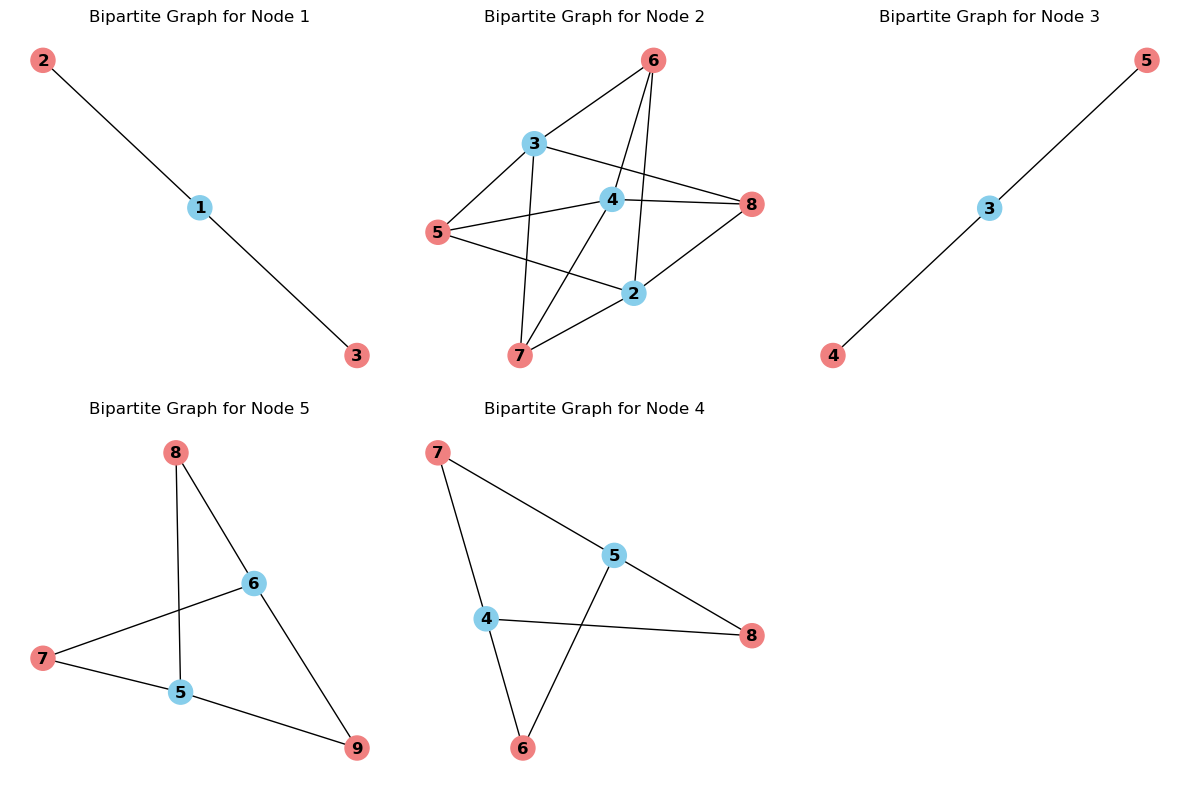

In [4]:
# Create bipartite graphs for each vertex
bipartite_graphs = [create_bipartite_graph(node, delta_values_dict[node], my_graph.degree(node)) for node in my_graph.nodes()]

# Display individual bipartite graphs
display_all_bipartite_graphs(bipartite_graphs)

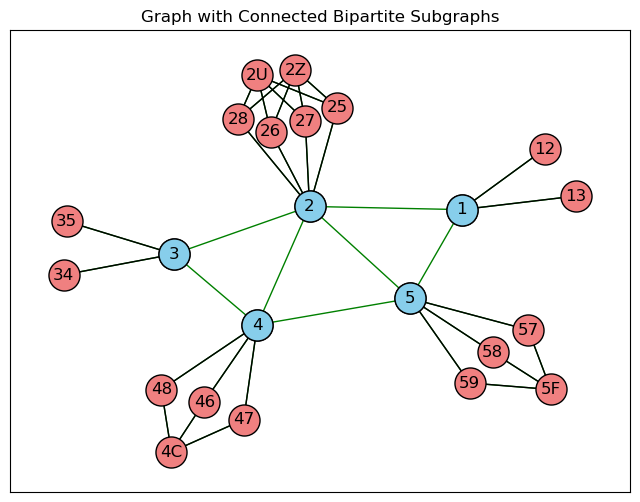

In [7]:
# Display the graph with connected bipartite subgraphs

com_graph = create_graph(grp)

pos_combined = nx.spring_layout(com_graph)

sub_graph_list = []

for edge in com_graph.edges():
    if edge not in my_graph.edges():
        sub_graph_list.append(edge) 


plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(com_graph, pos_combined, node_size=500, node_color= 'lightcoral', edgecolors='black', linewidths=1.0)
nx.draw_networkx_nodes(com_graph, pos_combined, nodelist = my_graph.nodes(),  node_color="skyblue", node_size=500, edgecolors='black', linewidths=1.0)
nx.draw_networkx_edges(com_graph, pos_combined, edge_color='green')
nx.draw_networkx_edges(com_graph, pos_combined, edgelist=sub_graph_list, edge_color='black')
nx.draw_networkx_labels(com_graph, pos_combined, font_size=12, font_color='black')

plt.title("Graph with Connected Bipartite Subgraphs")
plt.show()

In [9]:
# Example usage:
matching = nx.algorithms.matching.max_weight_matching(com_graph, maxcardinality=False)
print("Matching:", matching)

Matching: {('59', 5), ('48', 4), ('2U', '26'), ('13', 1), ('2Z', '25'), ('5F', '57'), ('28', 2), ('4C', '46'), ('35', 3)}
